<a href="https://colab.research.google.com/github/najjarfred/Week-2-Word-Embeddings-and-Representation/blob/NLP-Subject/COMP_4446_5046_Assignment1_moal9049.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2023 COMP 4446 / 5046 Assignment 1

Assingment 1 is an **individual** assessment. Please note the University's [Academic dishonesty and plagiarism policy](https://www.sydney.edu.au/students/academic-dishonesty.html).

Submission Deadline: Friday, March 17th, 2023, 11:59pm

Submit via Canvas:
- Your notebook
- Run all cells before saving the notebook, so we can see your output

In this assignment, we will explore ways to predict the length of a Wikipedia article based on the first 100 tokens in the article. Such a model could be used to explore whether there are systematic biases in the types of articles that get more detail.

If you are working in another language, please make sure to clearly indicate which part of your code is running which section of the assignment and produce output that provides all necessary information. Submit your code, example outputs, and instructions for executing it.

Note: This assignment contains topics that are not covered at the time of release. Each section has information about which lectures and/or labs covered the relevant material. We are releasing it now so you can (1) start working on some parts early, and (2) know what will be in the assignment when you attend the relevant labs and lectures.

# **TODO: Copy and Name this File**
Make a copy of this notebook in your own Google Drive (File -> Save a Copy in Drive) and change the filename, replacing `YOUR-UNIKEY`. For example, for a person with unikey `mcol1997`, the filename should be:

`COMP-4446-5046_Assignment1_mcol1997.ipynb`

# Readme
*If there is something you want to tell the marker about your submission, please mention it here.* 

[write here - optional]

# Data Download [DO NOT MODIFY THIS]

We have already constructed a dataset for you using a recent dump of data from Wikipedia. Both the training and test datasets are provided in the form of csv files (training_data.csv, test_data.csv) and can be downloaded from Google Drive using the code below. Each row of the data contains:

- The length of the article
- The title of the article
- The first 100 tokens of the article

In case you are curious, we constructed this dataset as follows:
1. Downloaded [a recent dump](https://dumps.wikimedia.org/) of English wikipedia.
2. Ran [WikiExtractor](https://github.com/attardi/wikiextractor) to get the contents of the pages.
3. Filtered out very short pages.
4. Ran [SpaCy](https://spacy.io/) with the `en_core_web_lg` model to tokenise the pages (Note, SpaCy's development is led by an alumnus of USyd!).
5. Counted the tokens and saved the relevant data in the format described above.

This code will download the data. **DO NOT MODIFY IT**

In [1]:
## DO NOT MODIFY THIS CODE
# Code to download files into Colaboratory

# Install the PyDrive library
!pip install -U -q PyDrive

# Import libraries for accessing Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Function to read the file, save it on the machine this colab is running on, and then read it in
import csv
def read_file(file_id, filename):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(filename)
  with open(filename) as src:
    reader = csv.reader(src)
    data = [r for r in reader]
  return data

# Calls to get the data
# If you need to access the data directly (e.g., you are running experiments on a local machine), use these links:
# - Training, https://drive.google.com/file/d/1-UGFS8D-qglAX-czU38KaM4jQVCoNe0W/view?usp=share_link
# - Dev, https://drive.google.com/file/d/1RWMEf0mdJMTkWc7dvN0ioks8bjujqZaN/view?usp=share_link
# - Test, https://drive.google.com/file/d/1YVPNzdIFSMmVPeLBP-gf5DOIed3oRFyB/view?usp=share_link
training_data = read_file('1-UGFS8D-qglAX-czU38KaM4jQVCoNe0W', "/content/training_data.csv")
dev_data = read_file('1RWMEf0mdJMTkWc7dvN0ioks8bjujqZaN', "/content/dev_data.csv")
test_data = read_file('1YVPNzdIFSMmVPeLBP-gf5DOIed3oRFyB', "/content/test_data.csv")

print("------------------------------------")
print("Size of training data: {0}".format(len(training_data)))
print("Size of development data: {0}".format(len(dev_data)))
print("Size of test data: {0}".format(len(test_data)))
print("------------------------------------")

print("------------------------------------")
print("Sample Data")
print("LABEL: {0} / SENTENCE: {1}".format(training_data[0][0], training_data[0][1:]))
print("------------------------------------")

# Preview of the data in the csv file, which has three columns: 
# (1) length of article, (2) title of the article, (3) first 100 words in the article
for v in training_data[:10]:
  print("{}\n{}\n{}\n".format(v[0], v[1], v[2][:100] + "..."))

# Store the data in lists and mofidy the length value to be in [0, 1]
training_lengths = [min(1.0, int(r[0])/10000) for r in training_data]
training_text = [r[2] for r in training_data]

dev_lengths = [min(1.0, int(r[0])/10000) for r in dev_data]
dev_text = [r[2] for r in dev_data]

test_lengths = [min(1.0, int(r[0])/10000) for r in test_data]
test_text = [r[2] for r in test_data]

------------------------------------
Size of training data: 9859
Size of development data: 994
Size of test data: 991
------------------------------------
------------------------------------
Sample Data
LABEL: 6453 / SENTENCE: ['Anarchism', 'Anarchism is a political philosophy and movement that is skeptical of all justifications for authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy , typically including , though not necessarily limited to , governments , nation states , and capitalism . Anarchism advocates for the replacement of the state with stateless societies or other forms of free associations . As a historically left - wing movement , usually placed on the farthest left of the political spectrum , it is usually described alongside communalism and libertarian Marxism as the libertarian wing ( libertarian socialism )']
------------------------------------
6453
Anarchism
Anarchism is a political philosophy and movement that is ske

# 1 - Predicting article length from initial content

This section relates to content from **the week 1 lecture and the week 2 lab**.

In this section, you will implement training and evaluation of a linear model (as seen in the week 2 lab) to predict the length of a wikipedia article from its first 100 words. You will represent the text using a Bag of Words model (as seen in the week 1 lecture).

## 1.1 Word Mapping [2pt]

In the code block below, write code to go through the training data and for any word that occurs at least 10 times:
- Assign it a unique ID (consecutive, starting at 0)
- Place it in a dictionary that maps from the word to the ID

In [36]:
# Import packages 
from collections import Counter
import nltk
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import re

from nltk.corpus import stopwords
import string

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from torch.nn.functional import mse_loss

from gensim.models import Word2Vec
import warnings
import torch.nn as nn
warnings.simplefilter(action='ignore', category=FutureWarning)
import pprint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
word_counter = Counter()

# loop through the training data and tokenize the words
for doc in training_data:
    for w in doc[2].split(' '): 
        word_counter[w] += 1

# only keep words that occurs at least 10 times and assign an ID to each word 
word_counter = {k:v for k,v in word_counter.items() if v >= 10}
word_dict = {k:v for v,k in enumerate(word_counter.keys())}


## 1.2 Data to Bag-of-Words Tensors [2pt]

In the code block below, write code to prepare the data in PyTorch tensors.

The text should be converted to a bag of words (ie., a vector the length of the vocabulary in the mapping in the previous step, with counts of the words in the text).

In [4]:
# a function to create a BoW tensor 
def BoW_tensor(data): 
    tensor = torch.zeros(len(data), len(word_dict))
    for i, article in enumerate(data):
        words = article[2].split()
        for word in words:
            if word in word_dict:
                tensor[i, word_dict[word]] += 1
    return tensor
                
# create Bag of Words tensor for the training data
BoW_training_tensor = BoW_tensor(training_data) 

# create Bag of Words tensor for the dev data      
BoW_dev_tensor = BoW_tensor(dev_data)
            
# create Bag of Words tensor for the test data
BoW_test_tensor = BoW_tensor(test_data)

In [5]:
# Prep target vector with the total number of words in each article for building and training the model
def target_tensor(data): 
    tar_tensor = torch.zeros(len(data))
    for i in range(len(data)):
        tar_tensor[i] = int(data[i][0])
    return tar_tensor


# create training target vector
target_training_tensor = target_tensor(training_data).view(-1, 1)

# create dev target vector
target_dev_tensor = target_tensor(dev_data).view(-1, 1)

# create test target vector
target_test_tensor = target_tensor(test_data).view(-1, 1)



## 1.3 Model Creation [2pt]

Construct a linear model with an SGD optimiser (we recommend a learning rate of `1e-4`) and mean squared error as the loss.

In [6]:
# Your code goes here

# create linear model
linear_model = torch.nn.Linear(len(word_dict), 1)
optimiser = torch.optim.SGD(linear_model.parameters(), lr=1e-4)
error_loss = F.mse_loss

# Calculate MSE loss
loss = error_loss(linear_model(BoW_training_tensor), target_training_tensor)
print(loss)

tensor(22193612., grad_fn=<MseLossBackward0>)


## 1.4 Training [2pt]

Write a loop to train your model for 100 epochs, printing performance on the dev set every 10 epochs.

Epoch: 0000 dev loss= 22105320.00000000
Epoch: 0010 dev loss= 17963270.00000000
Epoch: 0020 dev loss= 15435111.00000000
Epoch: 0030 dev loss= 13888264.00000000
Epoch: 0040 dev loss= 12938576.00000000
Epoch: 0050 dev loss= 12352652.00000000
Epoch: 0060 dev loss= 11988622.00000000
Epoch: 0070 dev loss= 11760187.00000000
Epoch: 0080 dev loss= 11614798.00000000
Epoch: 0090 dev loss= 11520428.00000000


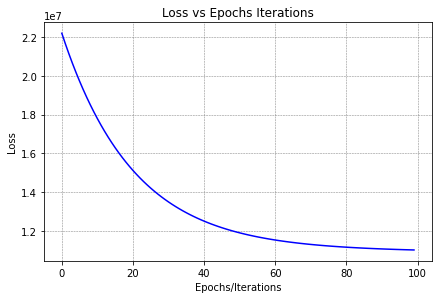

In [7]:
# An epoch is one iteration over the entire input data
no_of_epochs = 100

# How often you want to display training info.
display_interval = 10
loss_list = []

for epoch in range(no_of_epochs):
  predictions = linear_model(BoW_training_tensor)
  loss = error_loss(predictions, target_training_tensor)
  # storing the calculated loss in a list
  loss_list.append(loss.item())
  loss.backward()
  optimiser.step() #call step() to automatically update the parameters through our defined optimiser, which can be called once after backward()
  optimiser.zero_grad() #reset the gradient as what we did before
  if epoch % display_interval == 0 :
      # calculate the loss of the current model
      predictions = linear_model(BoW_dev_tensor)
      loss = error_loss(predictions, target_dev_tensor)          
      print("Epoch:", '%04d' % (epoch), "dev loss=", "{:.8f}".format(loss))
      
# Plotting the loss after each iteration
plt.plot(loss_list, 'b')
plt.tight_layout()
plt.grid('True', color='grey', linestyle='--', linewidth=0.5)
plt.xlabel("Epochs/Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Epochs Iterations")
plt.show()      

##### The error rate is decreasing, but it is still quite high. This is because the model is not able to capture the complexity of the data in the linear model. One way to increase the accuracy of this model is to increase the number of Epochs. However, this will increase the training time.

### Solution: 
- increase the number of Epochs 
- experiment with different learning rates


## 1.1 Measure Accuracy [2pt]

In the code block below, write code to evaluate your model on the test set.

In [8]:
# Your code goes here
print("=========================================================")
training_loss = error_loss(linear_model(BoW_training_tensor), target_training_tensor)
print("Optimised:", "training loss=", "{:.9f}".format(training_loss.data))
training_loss = error_loss(linear_model(BoW_dev_tensor), target_dev_tensor)   
print("Optimised:", "dev loss=", "{:.9f}".format(training_loss.data))
print("=========================================================")

# Calculate testing loss
testing_loss = error_loss(linear_model(BoW_test_tensor), target_test_tensor) 
print("Testing loss=", "{:.9f}".format(testing_loss.data))
print("Absolute mean square loss difference:", "{:.9f}".format(abs(
      training_loss.data - testing_loss.data)))

Optimised: training loss= 11018120.000000000
Optimised: dev loss= 11462783.000000000
Testing loss= 9901236.000000000
Absolute mean square loss difference: 1561547.000000000


##### The model is quite bad in predicting the length of the articles. The test set loss rate is in millions! 

## 1.2 Analyse the Model [2pt]

In the code block below, write code to identify the 50 words with the highest weights and the 50 words with the lowest weights.

In [9]:
# Your code goes here
# In the code block below, write code to identify the 50 words with the highest weights and the 50 words with the lowest weights.
highest_weights = []
lowest_weights = []

# get the weights of the linear model
highest_weights = linear_model.weight[0].data.sort(descending=True)[1][:50]
lowest_weights = linear_model.weight[0].data.sort(descending=False)[1][:50]

# get the words with the highest weights from the word_dict
highest_weights_words = sorted([k for k,v in word_dict.items() if v in highest_weights],
                                        key=lambda x: highest_weights.tolist().index(word_dict[x]))
            
# get the words with the lowest weights from the word_dict
lowest_weights_words = sorted([k for k,v in word_dict.items() if v in lowest_weights],
                                        key=lambda x: lowest_weights.tolist().index(word_dict[x]))  

Top 50 Words by Weight: 
[',', 'the', 'of', 'and', '.', 'in', 'a', 'is', 'to', ')', '"', '(', 'as', '-', 'The', 'was', 'by', 'an', 'with', 'or', 'from', 'that', 'for', ';', 'on', "'s", 'It', 'are', 'most', 'its', 'his', 'which', 'known', 'American', 'it', 'has', 'also', 'United', 'one', 'city', '–', 'largest', 'first', 'who', 'at', 'States', 'be', 'He', 'state', 'history']

'Lowest 50 Words by Weight:'
['History', 'Biography', 'affiliations', 'km', 'statistics', 'Emperor', 'article', 'Telecommunications', 'populace', 'Life', 'roads', 'density', 'road', 'Legislative', 'ethnicity', 'demographic', 'Executive', 'telephones', 'Population', 'letter', 'paved', 'framework', 'exercised', 'telephone', 'Transport', 'flowering', 'Norse', 'Geography', 'whereby', 'Radio', 'Telephones', 'son', 'Politics', 'Description', 'true', 'legislature', 'Railways', 'relations', 'Abbott', 'infrastructure', 'month', 'legendary', 'stations', 'vested', 'airports', 'Science', 'calendars', 'Burundi', 'Group', 'highwa

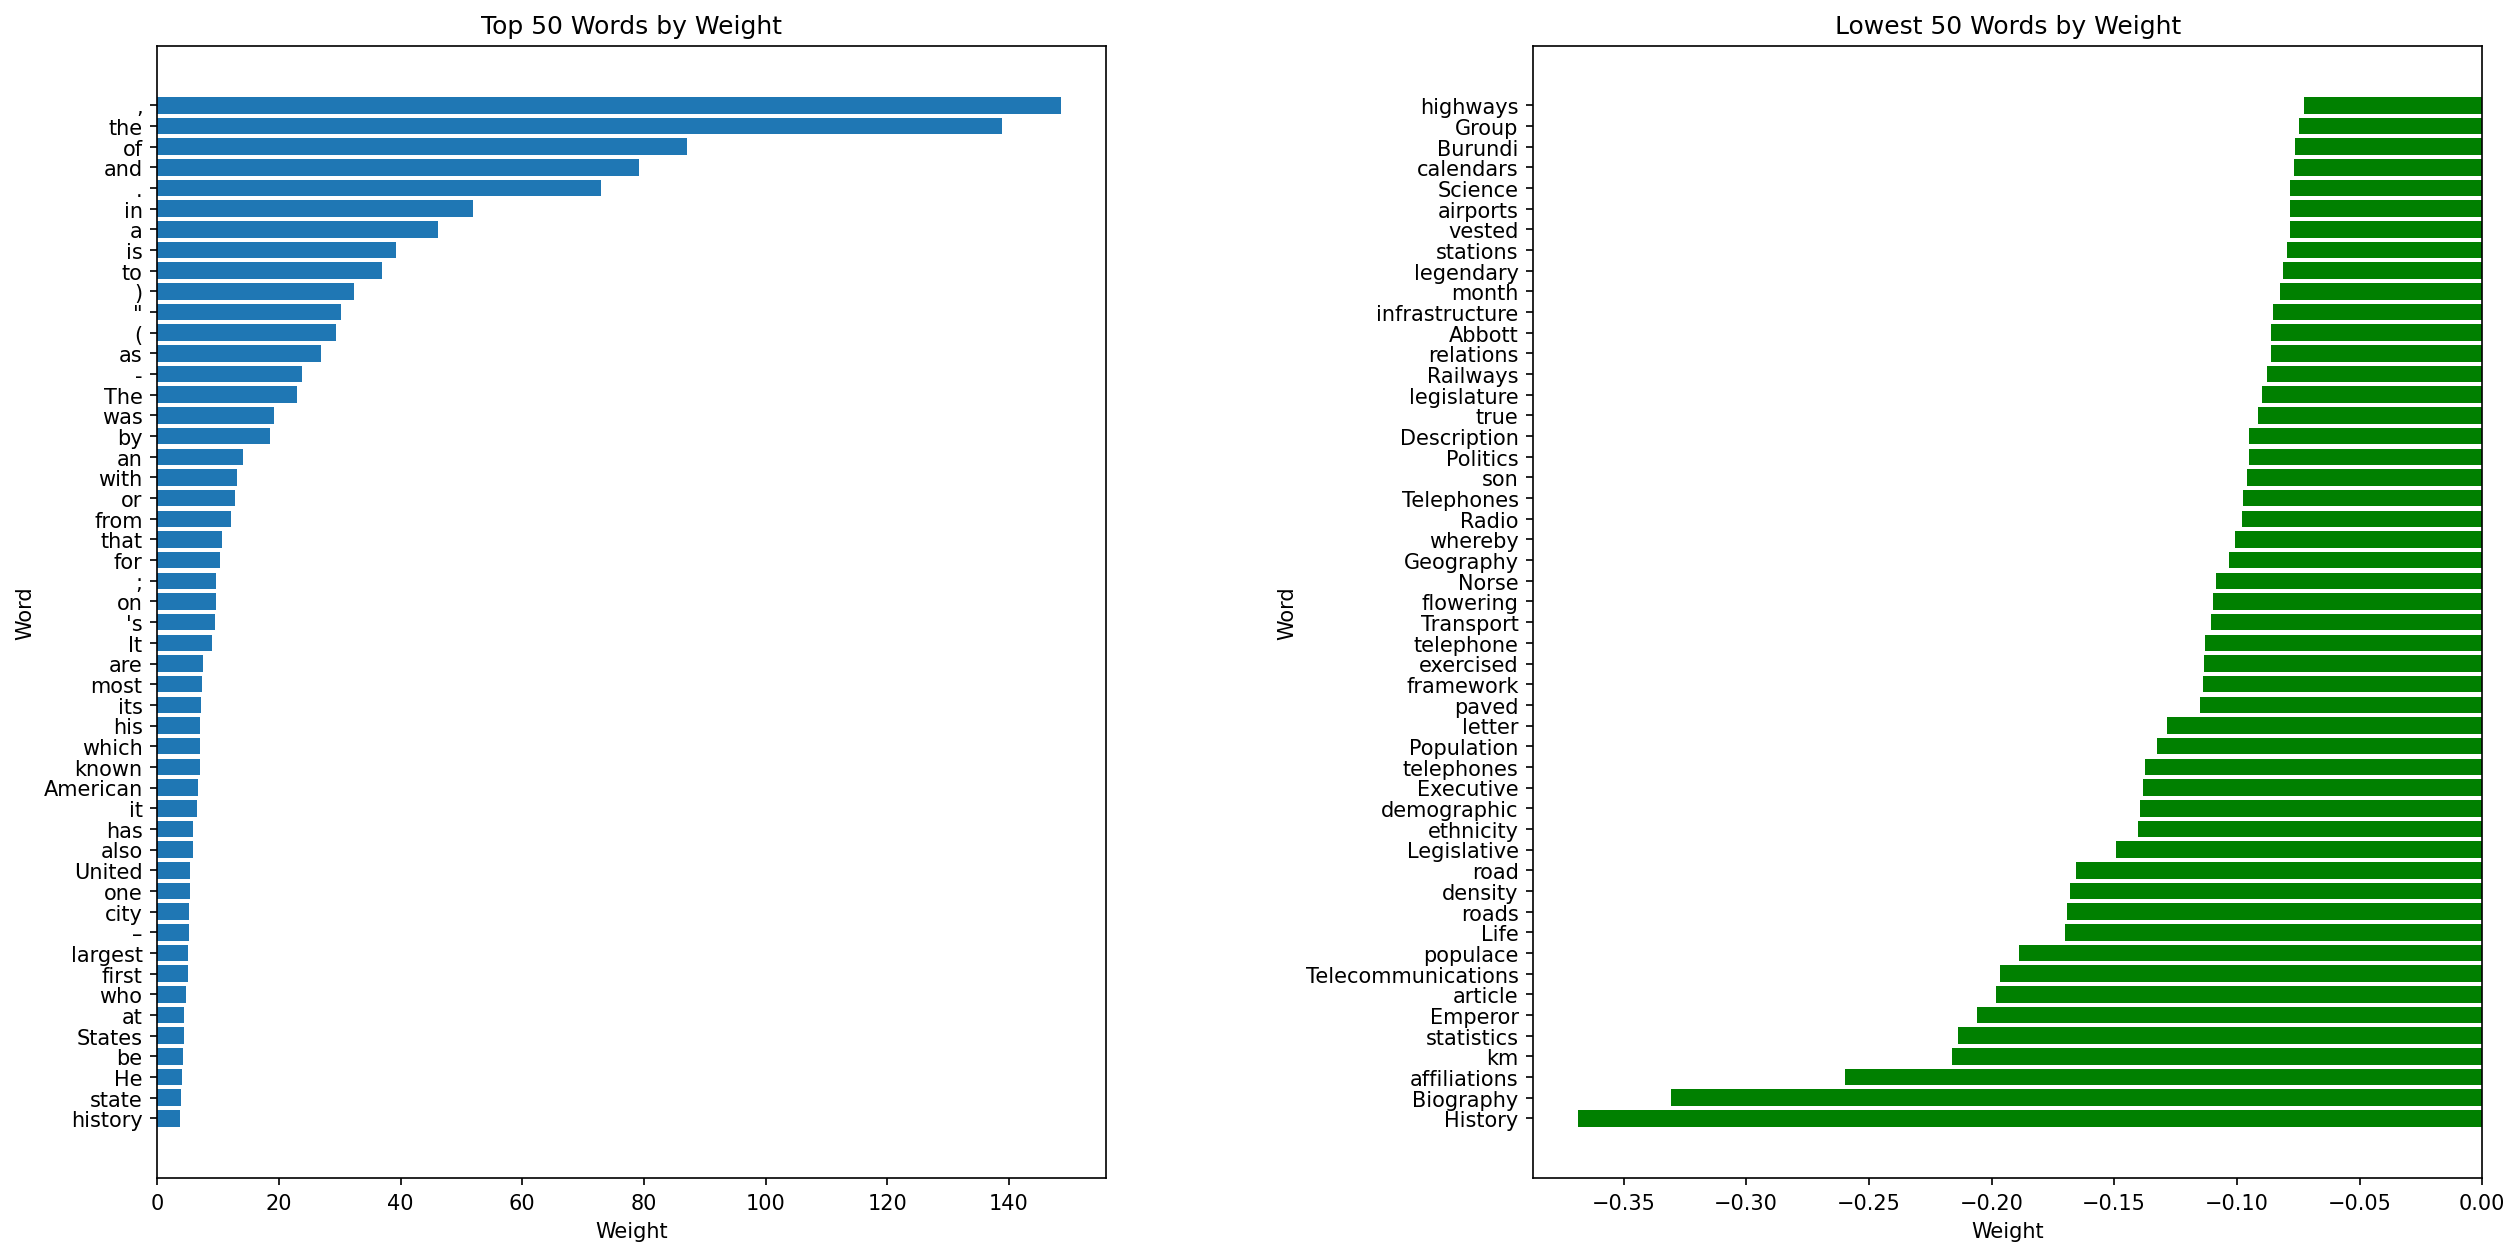

In [10]:
print(f"Top 50 Words by Weight: \n==================================================================================================================")
print(f'{highest_weights_words}\n')
print(f"'Lowest 50 Words by Weight:'\n==================================================================================================================")
print(lowest_weights_words)
print(f"\n==================================================================================================================")

# plot 
plt.figure(figsize=(20, 10), dpi=150)
plt.subplots_adjust(wspace=0.45)

plt.subplot(1, 2, 1)
sorted_weights, sorted_words = zip(*sorted(zip(linear_model.weight[0].data[highest_weights], highest_weights_words), reverse=False))
plt.barh(sorted_words, sorted_weights)
plt.title("Top 50 Words by Weight")
plt.xlabel("Weight")
plt.ylabel("Word")

plt.subplot(1, 2, 2)
plt.barh(lowest_weights_words, linear_model.weight[0].data[lowest_weights], color='g')
plt.title("Lowest 50 Words by Weight")
plt.xlabel("Weight")
plt.ylabel("Word")
plt.show()


#### the words with the highest weights are mostly stop words and names this because there was no preprocessing done on the training data, there is also the issue of words with different title cases and punctuations (e.g. the, The, etc.) being treated as different words. 

### Solution: 
- Preprocess the data by removing stop words, punctuations, and lower casing the words.
- Use a more complex model (e.g. LSTM, etc.)

# 2 - Compare Data Storage Methods

This section relates to content from **the week 1 lecture and the week 2 lab**.

Implement a variant of the model with a sparse vector for your input bag of words (See https://pytorch.org/docs/stable/sparse.html for how to switch a vector to be sparse). Use the default sparse vector type (COO).

In [11]:
# Your code goes here
def sparse_coo(data): 
    sparse = torch.sparse_coo_tensor(data.nonzero().t(), 
                            data[data.nonzero().t()[0],
                            data.nonzero().t()[1]],
                            data.size())
    return sparse 

BoW_training_sparse = sparse_coo(BoW_training_tensor)
target_training_sparse = sparse_coo(target_training_tensor)
BoW_dev_sparse = sparse_coo(BoW_dev_tensor) 
target_dev_sparse = sparse_coo(target_dev_tensor)
BoW_test_sparse = sparse_coo(BoW_test_tensor)
target_test_sparse = sparse_coo(target_test_tensor)


## 2.1 Training and Test Speed [2pt]
Compare the time it takes to train and test the new model with the time it takes to train and test the old model.

You can time the execution of a line of code using `%time`.
See [this guide](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb#scrollTo=z1gyaC_PNZUB) for more on timing.

In [12]:
%%timeit
# An epoch is one iteration over the entire input data
no_of_epochs = 100

# create linear model
spar_linear_model = torch.nn.Linear(len(word_dict), 1)
spar_optimiser = torch.optim.SGD(spar_linear_model.parameters(), lr=1e-4)
spar_error_loss = F.mse_loss

for epoch in range(no_of_epochs):
  predictions = spar_linear_model(BoW_training_sparse)
  loss = spar_error_loss(predictions, target_training_tensor)
  # storing the calculated loss in a list
  loss.backward()
  spar_optimiser.step() #call step() to automatically update the parameters through our defined optimiser, which can be called once after backward()
  spar_optimiser.zero_grad() #reset the gradient as what we did before
  


3.56 s ± 907 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit

# An epoch is one iteration over the entire input data
no_of_epochs = 100

# create linear model
tens_linear_model = torch.nn.Linear(len(word_dict), 1)
tens_optimiser = torch.optim.SGD(tens_linear_model.parameters(), lr=1e-4)
tens_error_loss = F.mse_loss

for epoch in range(no_of_epochs):
  predictions = tens_linear_model(BoW_training_tensor)
  loss = tens_error_loss(predictions, target_training_tensor)
  loss.backward()
  tens_optimiser.step() #call step() to automatically update the parameters through our defined optimiser, which can be called once after backward()
  tens_optimiser.zero_grad() #reset the gradient as what we did before
  

6.81 s ± 1.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
print(f"Training the model using COO sparse tensor is {round((1-(3.56/6.81))*100,1)}% faster than training the model using the regular tensor")

Training the model using COO sparse tensor is 23.5% faster than training the model using the regular tensor


# 3 - Switch to Word Embeddings

This section relates to content from **the week 2 lecture and the week 3 lab**.

In this section, you will implement a model based on word2vec.

1. Use word2vec to learn embeddings for the words in your data.
2. Represent each input document as the average of the word vectors for the words it contains.
3. Train a linear regression model.

In [15]:

# implement a model based on word2vec.

# 1. Use word2vec to learn embeddings for the words in your data.
tokenized_training_data = [article[2].lower().split() for article in training_data]


# word2vec model 
w2v_model = Word2Vec(tokenized_training_data, size=100, window=5, min_count=10, workers=4)

# 2. Represent each input document as the average of the word vectors for the words it contains.
def get_average_word2vec(data): 
    vector = torch.zeros(w2v_model.wv.vectors.shape[1])
    for word in data:
        if word in w2v_model.wv:
            vector += torch.tensor(w2v_model.wv[word])
    return vector/len(data)
    
w2v_tensor = (torch.stack([get_average_word2vec(data) for data in tokenized_training_data]))

# 3. Train a linear regression model.
w2v_linear_model = torch.nn.Linear(w2v_tensor.shape[1], 1)
w2v_optimiser = torch.optim.SGD(w2v_linear_model.parameters(), lr=1e-4)
w2v_error_loss = F.mse_loss

w2v_error = [] 

w2v_epoch = 100
w2v_epoch_interval = 10
for epoch in range(w2v_epoch):
    predictions = w2v_linear_model(w2v_tensor)
    loss = w2v_error_loss(predictions, target_training_tensor)
    loss.backward()
    w2v_error.append(loss.item())
    w2v_optimiser.step() #call step() to automatically update the parameters through our defined optimiser, which can be called once after backward()
    w2v_optimiser.zero_grad() #reset the gradient as what we did before
    
    if (epoch+1) % w2v_epoch_interval == 0:
        loss = w2v_error_loss(predictions, target_training_tensor).item()
        accuracy = (1 - (loss/w2v_tensor.shape[0])) * 100
        print(f"Epoch: {epoch+1}, Loss: {loss:.0f}, Accuracy: {accuracy:.1f}%")


Epoch: 10, Loss: 21998884, Accuracy: -223035.0%
Epoch: 20, Loss: 21785284, Accuracy: -220868.5%
Epoch: 30, Loss: 21575876, Accuracy: -218744.5%
Epoch: 40, Loss: 21370580, Accuracy: -216662.1%
Epoch: 50, Loss: 21169312, Accuracy: -214620.7%
Epoch: 60, Loss: 20972002, Accuracy: -212619.4%
Epoch: 70, Loss: 20778560, Accuracy: -210657.3%
Epoch: 80, Loss: 20588914, Accuracy: -208733.7%
Epoch: 90, Loss: 20402994, Accuracy: -206847.9%
Epoch: 100, Loss: 20220720, Accuracy: -204999.1%


## 3.1 Accuracy [1pt]

Calculate the accuracy of your model.

The model accuracy is: -204999.1%


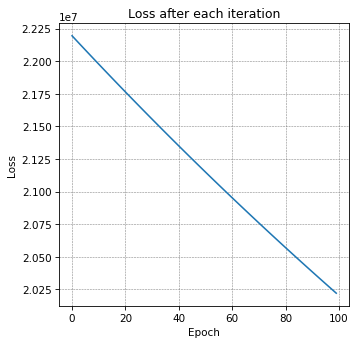

In [16]:
print(f"The model accuracy is: {accuracy:.1f}%")

# Plotting the loss after each iteration
plt.figure(figsize=(5, 5), dpi=75)
plt.plot(range(w2v_epoch), w2v_error)
plt.grid('True', color='grey', linestyle='--', linewidth=0.5)
plt.title("Loss after each iteration")
plt.xlabel("Epoch")
plt.ylabel("Loss") 
plt.show()

## 3.2 Speed [1pt]

Calcualte how long it takes your model to be evaluated.

In [17]:
%%timeit 

# 3. Train a linear regression model.
w2v_linear_model = torch.nn.Linear(w2v_tensor.shape[1], 1)
w2v_optimiser = torch.optim.SGD(w2v_linear_model.parameters(), lr=1e-4)
w2v_error_loss = F.mse_loss

w2v_epoch = 100
for epoch in range(w2v_epoch):
    predictions = w2v_linear_model(w2v_tensor)
    loss = w2v_error_loss(predictions, target_training_tensor)
    loss.backward()
    w2v_optimiser.step() #call step() to automatically update the parameters through our defined optimiser, which can be called once after backward()
    w2v_optimiser.zero_grad() #reset the gradient as what we did before


71.7 ms ± 8.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


As we can see from the table below, the Word2Vec model is significantly faster than the Bag-of-Words models. This makes sense as the Word2Vec model had a smaller input vector size of 100, while the models with Sparse and Regualr Vectors had the entire dataset. However, the BoW model performance outperforms the Word2Vec model. 

| Model | Training Time |
| ----- | ------------ |
| Word2Vec with Regualr Tensor | 79.2 ms ± 11.1 ms |
| Bag of Words with Sparse Tensor | 	4.17 s ± 1.46 s |
| Bag of Words with Regualr Tensor | 5.45 s ± 112 ms |


# 4 - Open-Ended Improvement

This section relates to content from **the week 1, 2, and 3 lectures and the week 1, 2, and 3 labs**.

This section is an open-ended opportunity to find ways to make your model more accurate and/or faster (e.g., use WordNet to generalise words, try different word features, other optimisers, etc).

We encourage you to try several ideas to provide scope for comparisons.

If none of your ideas work you can still get full marks for this section. You just need to justify the ideas and discuss why they may not have improved performance.


## 4.1 Ideas and Motivation [1pt]

In **this** box, describe your ideas and why you think they will improve accuracy and/or speed.

To improve accuracy and/or speed in text classification, we can:
- Increase the number of epochs (but this might decrease the speed)
- Experiment with different learning rates
- Experiment with different Gradient Descent Algorithms (i.e. Adam)
- Preprocess the data by removing stop words, punctuations, and lower casing the words
- Use a more complex model (e.g. LSTM, etc.)
- Add word embeddings to the model.

## 4.2 Implementation [2pt]

Implement your ideas

In [23]:
# process dataset: 

def preprocess_text(text, stop_words):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove whitespace
    text = text.strip()

    # Remove numbers and special characters
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Remove stop words
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    
    # Convert all words to lowercase 
    text = text.lower()
    
    # Remove leading and trailing whitespace
    text = text.strip()
    
    # remove words with length less than 2
    text = ' '.join([word for word in text.split() if len(word) > 2])
    
    return text

processed_training_data = [preprocess_text(article[2], stop_words) for article in training_data]
processed_dev_data = [preprocess_text(article[2], stop_words) for article in dev_data]
processed_test_data = [preprocess_text(article[2], stop_words) for article in test_data]

In [24]:
# remove remove words that occurs less than 10 times and create a dictionary of words and their IDs
processed_word_counter = Counter()

for doc in processed_training_data:
    for w in doc.split(' '): 
        processed_word_counter[w] += 1

processed_word_counter = {k:v for k,v in processed_word_counter.items() if v >= 10}
processed_word_dict = {k:v for v,k in enumerate(processed_word_counter.keys())}


In [25]:
# a function to create a BoW tensor 
def BoW_tensor(data): 
    tensor = torch.zeros(len(data), len(processed_word_dict))
    for i, article in enumerate(data):
        words = article.split()
        for word in words:
            if word in processed_word_dict:
                tensor[i, processed_word_dict[word]] += 1
    return tensor


processed_BoW_training_tensor = BoW_tensor(processed_training_data) 
processed_BoW_dev_tensor = BoW_tensor(processed_dev_data)
processed_BoW_test_tensor = BoW_tensor(processed_test_data)

In [26]:
# create linear model
pro_linear_model = torch.nn.Linear(len(processed_word_dict), 1)
pro_optimiser = torch.optim.SGD(pro_linear_model.parameters(), lr=1e-2) # increase learning rate
pro_error_loss = F.mse_loss

pro_loss = pro_error_loss(pro_linear_model(processed_BoW_training_tensor), target_training_tensor)
print(pro_loss)

tensor(22194016., grad_fn=<MseLossBackward0>)


Epoch: 0000 dev loss= 21703152.00000000
Epoch: 10000 dev loss= 9725124.00000000
Epoch: 20000 dev loss= 10577844.00000000
Epoch: 30000 dev loss= 11283932.00000000
Epoch: 40000 dev loss= 11895372.00000000
Epoch: 50000 dev loss= 12441179.00000000
Epoch: 60000 dev loss= 12937356.00000000
Epoch: 70000 dev loss= 13393684.00000000
Epoch: 80000 dev loss= 13816776.00000000
Epoch: 90000 dev loss= 14211399.00000000


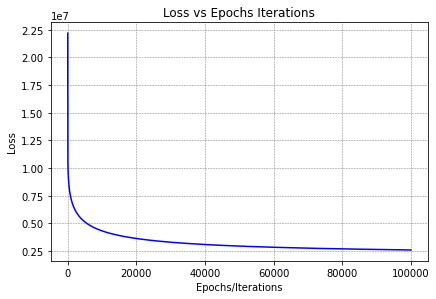

In [27]:
# train the model
no_of_epochs = 100000 # increased number of epochs

# How often you want to display training info.
display_interval = 10000
pro_loss_list = []

# Training loop 
for epoch in range(no_of_epochs):
  pro_predictions = pro_linear_model(processed_BoW_training_tensor)
  pro_loss = pro_error_loss(pro_predictions, target_training_tensor)
  # storing the calculated loss in a list
  pro_loss_list.append(pro_loss.item())
  pro_loss.backward()
  pro_optimiser.step() #call step() to automatically update the parameters through our defined optimiser, which can be called once after backward()
  pro_optimiser.zero_grad() #reset the gradient as what we did before
  if epoch % display_interval == 0 :
    # calculate the loss of the current model on dev set
    predictions = pro_linear_model(processed_BoW_dev_tensor)
    pro_loss = pro_error_loss(predictions, target_dev_tensor) 
    print("Epoch:", '%04d' % (epoch), "dev loss=", "{:.8f}".format(pro_loss))


# Plotting the loss after each iteration
plt.plot(pro_loss_list, 'b')
plt.tight_layout()
plt.grid('True', color='grey', linestyle='--', linewidth=0.5)
plt.xlabel("Epochs/Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Epochs Iterations")
plt.show()      

In [28]:
# Your code goes here
print("=========================================================")
pro_training_loss = pro_error_loss(pro_linear_model(processed_BoW_training_tensor), target_training_tensor)
print("Optimised:", "training loss=", "{:.9f}".format(pro_training_loss.data))
pro_training_loss = pro_error_loss(pro_linear_model(processed_BoW_dev_tensor), target_dev_tensor)   
print("Optimised:", "dev loss=", "{:.9f}".format(pro_training_loss.data))
print("=========================================================")

# Calculate testing loss
pro_testing_loss = pro_error_loss(pro_linear_model(processed_BoW_test_tensor), target_test_tensor) 
print("Testing loss=", "{:.9f}".format(pro_testing_loss.data))
print("Absolute mean square loss difference:", "{:.9f}".format(abs(
      pro_training_loss.data - pro_testing_loss.data)))


Optimised: training loss= 2593706.500000000
Optimised: dev loss= 14581018.000000000
Testing loss= 13840494.000000000
Absolute mean square loss difference: 740524.000000000


Top 50 Words by Weight: 
['gospels', 'influencing', 'cello', 'rocky', 'multinational', 'lit', 'israelites', 'traced', 'manhattan', 'arrival', 'win', 'tibetan', 'lyrics', 'initials', 'missions', 'newfoundland', 'seizures', 'millennium', 'projected', 'statesman', 'humanitarian', 'maya', 'officially', 'legislation', 'separating', 'jurassic', 'habsburg', 'rite', 'thinking', 'buddha', 'bordered', 'dick', 'jointly', 'metaphysical', 'acceptance', 'guitarists', 'hispaniola', 'standardized', 'firearms', 'spanning', 'kingdoms', 'palestine', 'herbert', 'begins', 'stored', 'tribes', 'invaded', 'subculture', 'contribute', 'americans']

'Lowest 50 Words by Weight:'
['proto', 'follow', 'philadelphia', 'relief', 'employ', 'get', 'tanakh', 'summary', 'nominally', 'ties', 'southeastern', 'observatory', 'caucasus', 'maize', 'scattered', 'sporting', 'males', 'partner', 'memorial', 'geologic', 'biography', 'formulated', 'volunteer', 'surgical', 'affiliations', 'add', 'draws', 'affair', 'homeland', 'nomadic

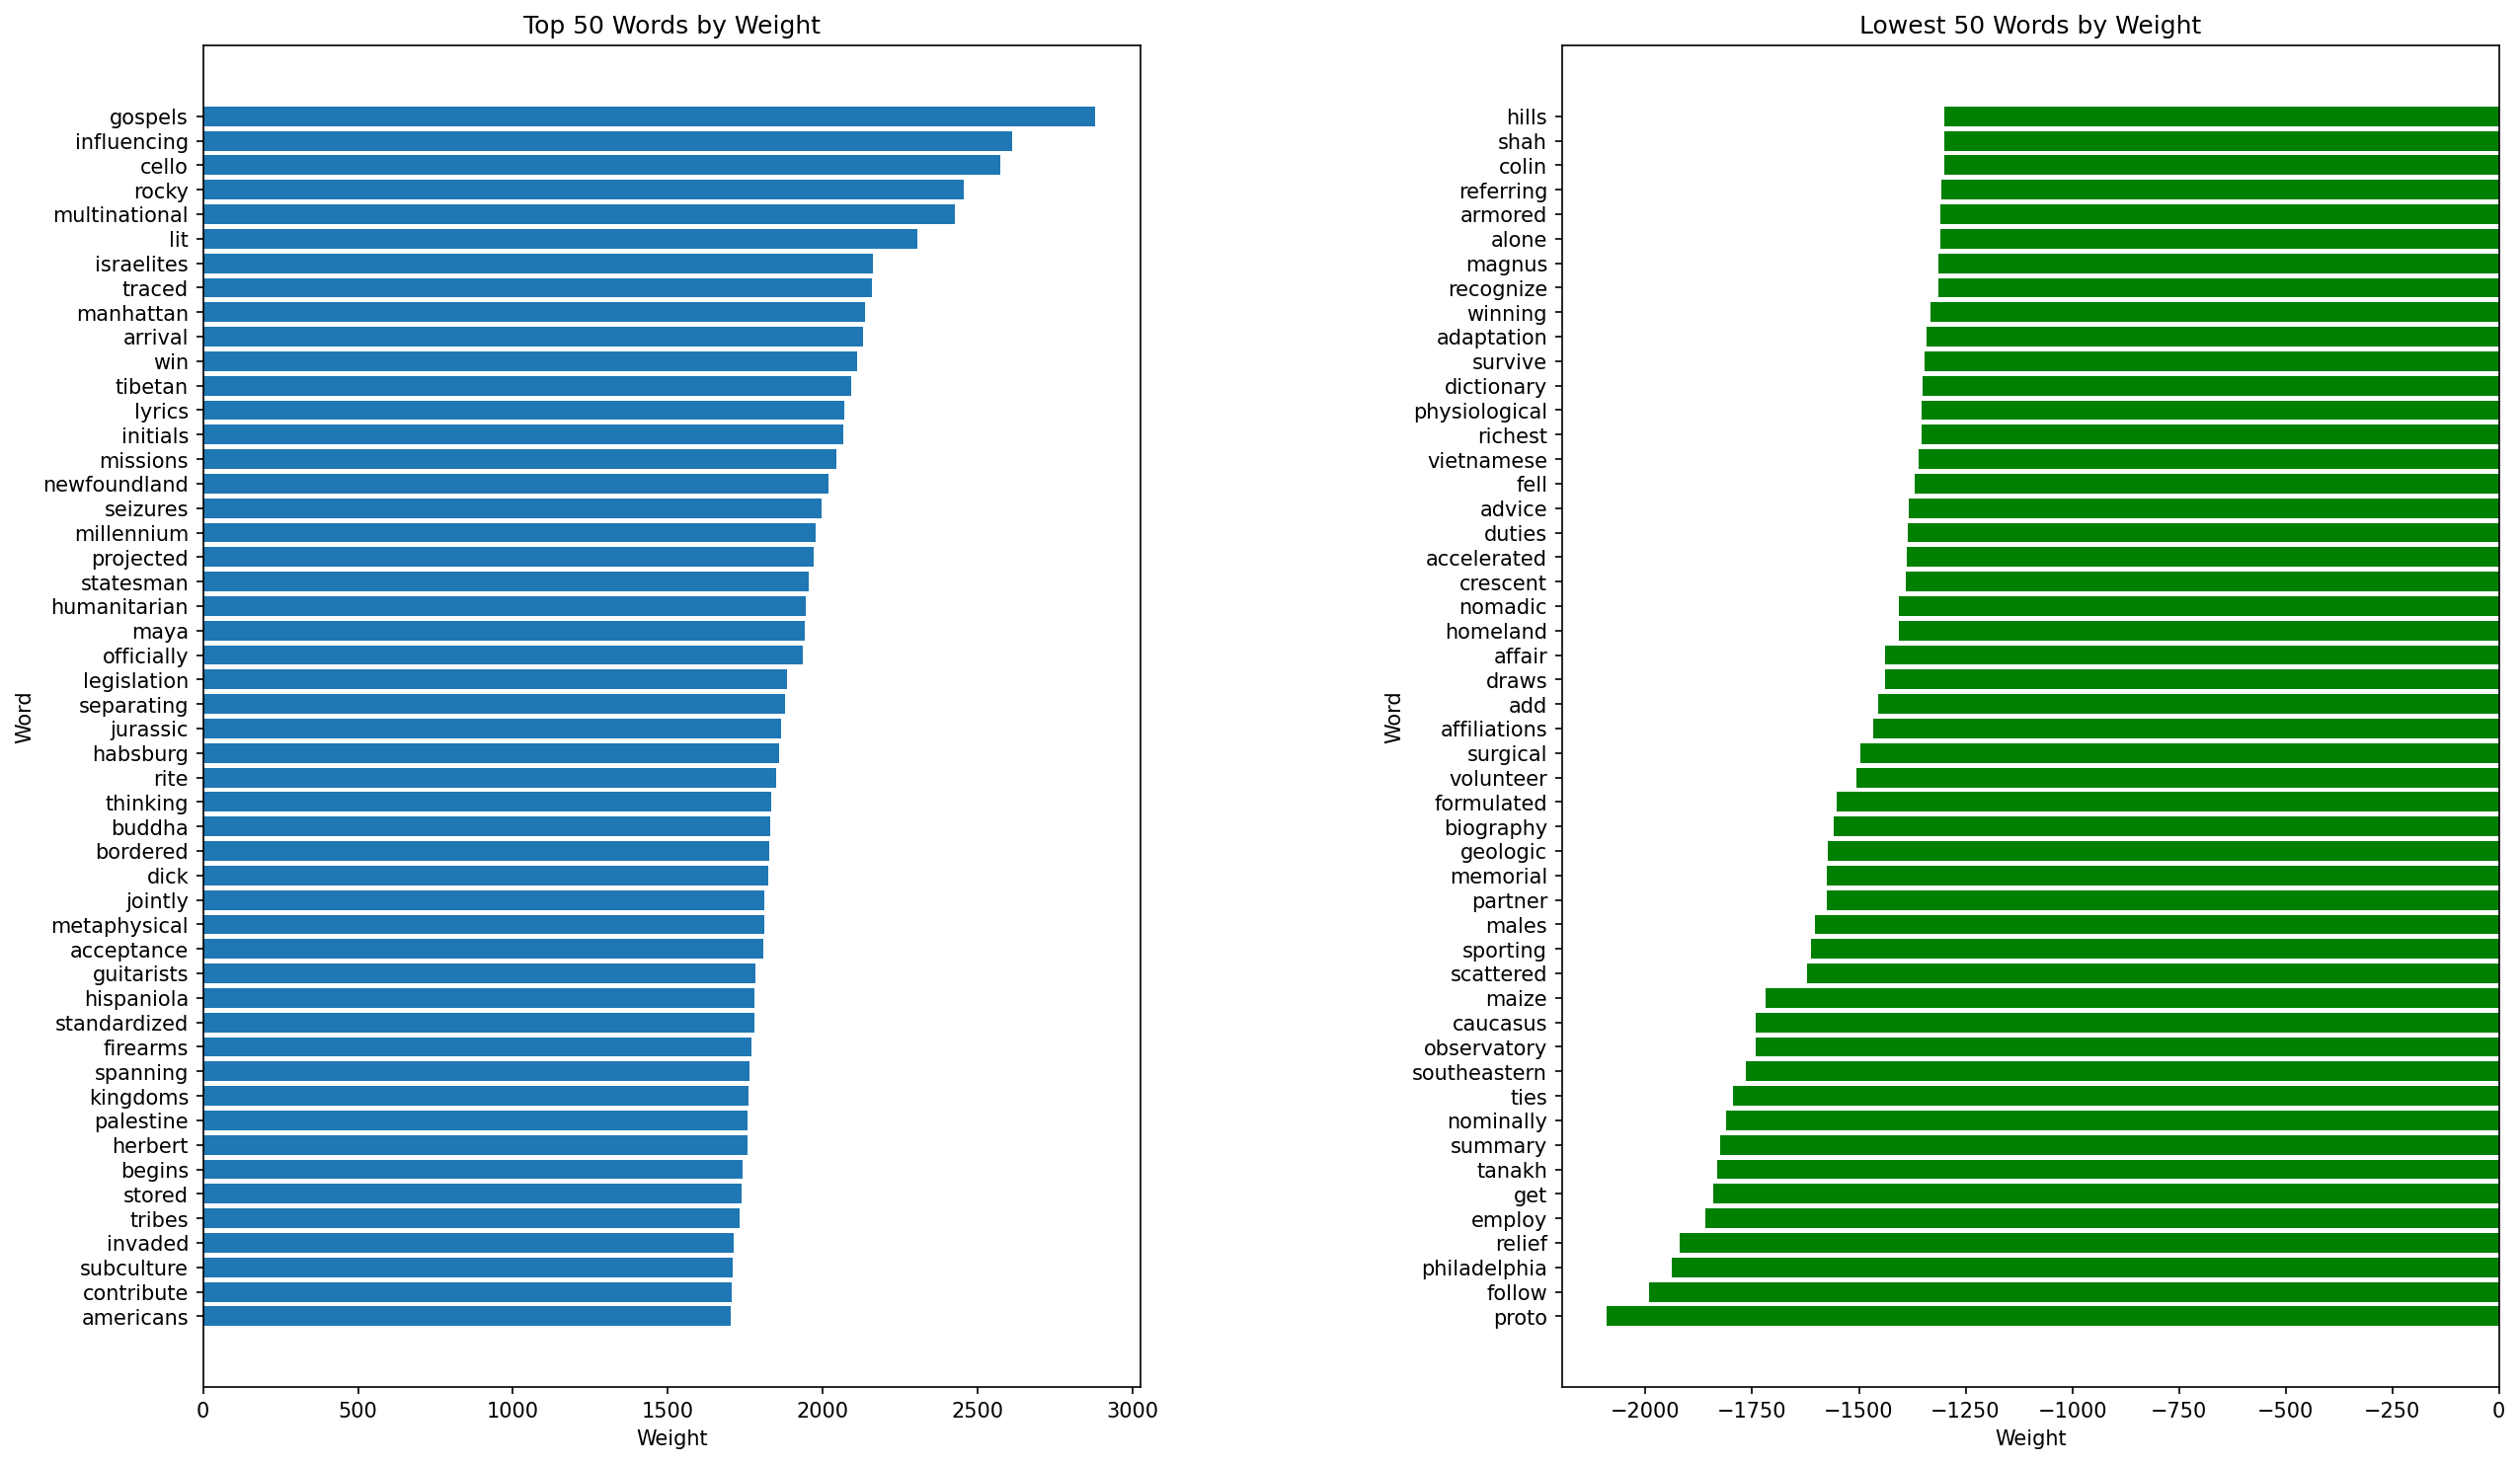

In [29]:
# Your code goes here
# In the code block below, write code to identify the 50 words with the highest weights and the 50 words with the lowest weights.
pro_highest_weights = []
pro_lowest_weights = []

# get the weights of the linear model
pro_highest_weights = pro_linear_model.weight[0].data.sort(descending=True)[1][:50]
pro_lowest_weights = pro_linear_model.weight[0].data.sort(descending=False)[1][:50]

# get the words with the highest weights from the word_dict
pro_highest_weights_words = sorted([k for k,v in processed_word_dict.items() if v in pro_highest_weights],
                                        key=lambda x: pro_highest_weights.tolist().index(processed_word_dict[x]))
            
# get the words with the lowest weights from the word_dict
pro_lowest_weights_words = sorted([k for k,v in processed_word_dict.items() if v in pro_lowest_weights],
                                        key=lambda x: pro_lowest_weights.tolist().index(processed_word_dict[x]))  


print(f"Top 50 Words by Weight: \n==================================================================================================================")
print(f'{pro_highest_weights_words}\n')
print(f"'Lowest 50 Words by Weight:'\n==================================================================================================================")
print(pro_lowest_weights_words)

# plot 
plt.figure(figsize=(20, 12), dpi=150)
plt.subplots_adjust(wspace=0.45)

plt.subplot(1, 2, 1)
pro_sorted_weights, pro_sorted_words = zip(*sorted(zip(pro_linear_model.weight[0].data[pro_highest_weights], pro_highest_weights_words), reverse=False))
plt.barh(pro_sorted_words, pro_sorted_weights)
plt.title("Top 50 Words by Weight")
plt.xlabel("Weight")
plt.ylabel("Word")

plt.subplot(1, 2, 2)
plt.barh(pro_lowest_weights_words, pro_linear_model.weight[0].data[pro_lowest_weights], color='g')
plt.title("Lowest 50 Words by Weight")
plt.xlabel("Weight")
plt.ylabel("Word")
plt.show()


## 4.3 Evaluation [1pt]

Evaluate the speed and accuracy of the model with your ideas

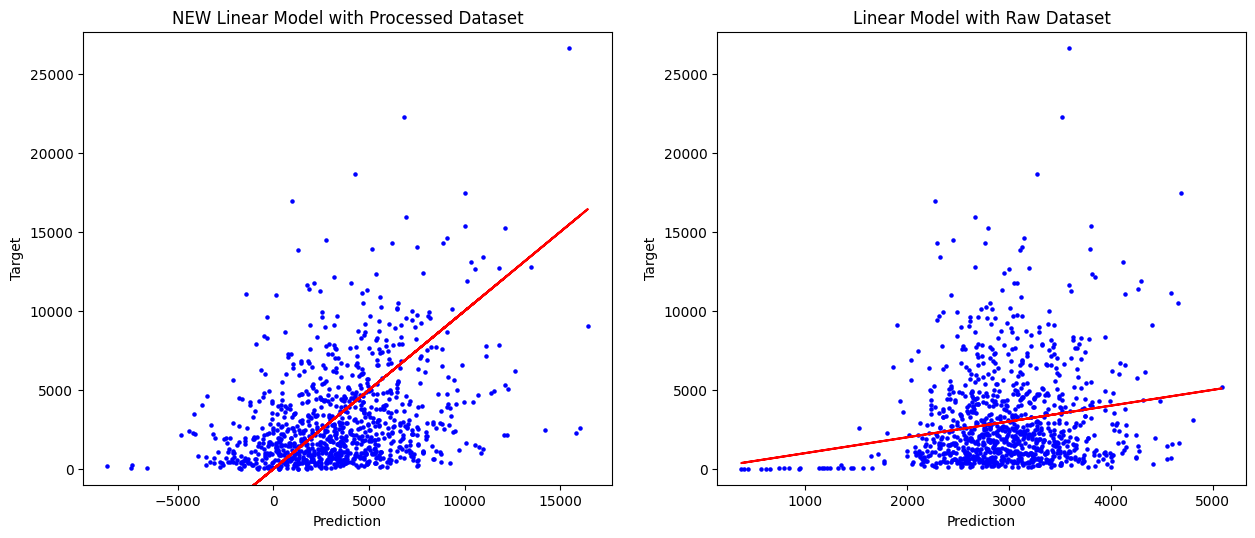

In [30]:
# create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=100)

# plot pro_linear_model prediction in second subplot
axs[0].scatter(pro_linear_model(processed_BoW_test_tensor).data, target_test_tensor.data, s=5, c='b')
axs[0].plot(pro_linear_model(processed_BoW_test_tensor).data, pro_linear_model(processed_BoW_test_tensor).data, 'r')
axs[0].set_ylim(-1000, target_test_tensor.data.max()+1000)
axs[0].set_title("NEW Linear Model with Processed Dataset")
axs[0].set_xlabel("Prediction")
axs[0].set_ylabel("Target")

# plot linear_model prediction in first subplot
axs[1].scatter(linear_model(BoW_test_tensor).data, target_test_tensor.data, s=5, c='b')
axs[1].plot(linear_model(BoW_test_tensor).data, linear_model(BoW_test_tensor).data, 'r')
axs[1].set_ylim(-1000, target_test_tensor.data.max()+1000)
axs[1].set_title("Linear Model with Raw Dataset")
axs[1].set_xlabel("Prediction")
axs[1].set_ylabel("Target")

plt.show()


In [35]:
print("NEW Linear Model with Processed Dataset")
print("=========================================================")
# Calculate testing loss
pro_testing_loss = pro_error_loss(pro_linear_model(processed_BoW_test_tensor), target_test_tensor) 
print("Testing loss=", "{:.1f}".format(pro_testing_loss.data))
print("Absolute mean square loss difference:", "{:.1f}".format(abs(
      pro_training_loss.data - pro_testing_loss.data)))

print(" ")

print("Linear Model with RAW Dataset")
print("=========================================================")
# Calculate testing loss
testing_loss = error_loss(linear_model(BoW_test_tensor), target_test_tensor) 
print("Testing loss=", "{:.1f}".format(testing_loss.data))
print("Absolute mean square loss difference:", "{:.1f}".format(abs(
      training_loss.data - testing_loss.data)))

NEW Linear Model with Processed Dataset
Testing loss= 13840494.0
Absolute mean square loss difference: 740524.0
 
Linear Model with RAW Dataset
Testing loss= 9901236.0
Absolute mean square loss difference: 1561547.0


The new approach taken by cleaning the dataset, increasing the training iteration, and updating the learning rate has significantly improved the accuracy of the model. This can be observed from the testing loss, which dropped by half in comparison to the linear model trained on the raw dataset. Additionally, the absolute mean square loss difference also decreased, indicating that the predicted values are closer to the actual values. 

The side-by-side comparison of the scatter plots confirms this improvement in accuracy, with the points on the scatter plot for the model trained on the processed dataset being more closely clustered around the line of best fit. Overall, these results demonstrate that the preprocessing steps have successfully improved the performance of the linear model.